# 03_stimuli_induced_timefreq

In [6]:
import numpy as np
from os.path import join as pjoin
import os
import matplotlib.pyplot as plt
import mne_bids
import mne
from mne_bids import write_raw_bids, BIDSPath
from scipy.signal import coherence

In [2]:
# %%
# define variables
sub_list = ['{0:0>2d}'.format(sub) for sub in np.arange(1,12)]
run_list = ['{0:0>2d}'.format(run) for run in np.arange(1,9)]

# set path
pre_root = '/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids'
post_root = pjoin(pre_root, 'derivatives', 'preproc_meg-mne_mri-fmriprep')

results_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results'
coherence_data_dir = pjoin(results_pth,'coherence')

if os.path.exists(coherence_data_dir) is False:
    os.makedirs(coherence_data_dir)

In [3]:
# define variables
def extract_megdata(bids_root, sub, run):

    sub_path = BIDSPath(subject=sub, run=run, task='movie', session='movie', root=bids_root)
    raw = mne_bids.read_raw_bids(sub_path)
    
    return raw

def extract_events(bids_root, sub, run):
    
    raw = extract_megdata(bids_root, sub, run)
    events = mne.find_events(raw, stim_channel='UPPT001', min_duration=2/raw.info['sfreq'])
    
    return events

def get_picks(data):
    # get valid channels
    ch_name_picks = mne.pick_channels_regexp(data.ch_names, regexp='M[LRZ]...-4503')
    type_picks = mne.pick_types(data.info, meg=True)
    picks= np.intersect1d(ch_name_picks, type_picks)
    return picks

In [4]:
def compute_tf(data_sub, events_sub, frame, baselinemode):
    
    picks = get_picks(data_sub)
    epochs = mne.Epochs(data_sub, events_sub[frame,:][None,...], tmin=-5, tmax=5, 
                        baseline=None, picks=picks, preload=True)
    
    decim = 5
    freqs = np.arange(1, 100, 1)
    tfr_epochs,_ = mne.time_frequency.tfr_morlet(epochs, freqs, n_cycles=4, decim=decim)
    
    tfr_epochs.apply_baseline(mode=baselinemode, baseline=(-1,0))

    del data_sub
    
    return tfr_epochs

In [ ]:
# compute time frequency
run_frame = {'01':21768, '03':15864}  # visual change clip in seg 1, audio change clip in seg 3

for run in run_frame.keys():
    tfr_data = []
    coh = []
    
    if run == '08':
        sub_ls = sub_list[1:]
    else:
        sub_ls = sub_list
    
    for sub in sub_ls:
        megdata = extract_megdata(post_root, sub, run)
        events = extract_events(post_root, sub, run)
        
        # compute ft
        tfr_epochs = compute_tf(megdata, events, run_frame[run], baselinemode='logratio')
        tfr_data.append(tfr_epochs.data)
             
        print(f'sub {sub} run {run} done')
    
    tfr_epochs.save(pjoin(results_pth, f'tfr_epochs_seg{run}'), overwrite=True)
    np.save(pjoin(results_pth, f'tfr_group_data_seg{run}.npy'), np.asarray(tfr_data).mean(0))

In [ ]:
# plot
# laod data
tfr_data_vis = np.load(pjoin(results_pth ,f'tfr_group_data_seg01.npy'))
tfr_data_aud = np.load(pjoin(results_pth ,f'tfr_group_data_seg03.npy'))
tfr_epochs = mne.time_frequency.read_tfrs(pjoin(results_pth, f'tfr_epochs_seg01'))[0]

# get group average
tfr_group_vis = tfr_epochs.copy()
tfr_group_vis.data = tfr_data_vis

tfr_group_aud = tfr_epochs.copy()
tfr_group_aud.data = tfr_data_aud

Text(0.5, 0, 'time (s)')

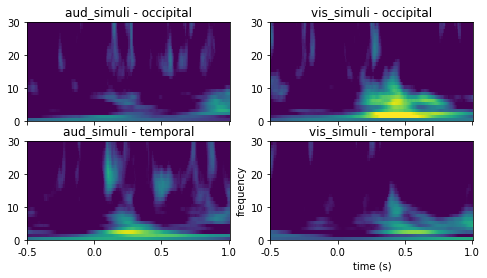

In [15]:
# meg layout
layout = mne.find_layout(tfr_epochs.info, 'meg')

#
tmin, tmax = -0.5, 1
fmax = 30
cmap = 'viridis'
vmin, vmax = -0.18, 0.18

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8, 4))

# audio stimuli - occipital sensors
data_plot = tfr_group_aud.copy().crop(tmin=tmin, tmax=tmax, fmax=fmax).pick(
    mne.pick_channels_regexp(tfr_group_aud.ch_names, regexp='M[LR]O...'))
axes.flatten()[0].pcolor(data_plot.data.mean(0), cmap=cmap, vmax=vmax , vmin=vmin)
axes.flatten()[0].set_title('aud_simuli - occipital')

# audio stimuli - temporal sensors
data_plot = tfr_group_aud.copy().crop(tmin=tmin, tmax=tmax, fmax=fmax).pick(
    mne.pick_channels_regexp(tfr_group_aud.ch_names, regexp='M[LR]T...'))
axes.flatten()[2].pcolor(data_plot.data.mean(0), cmap=cmap, vmax=vmax , vmin=vmin)
axes.flatten()[2].set_title('aud_simuli - temporal')

# visual stimuli - occipital sensors
data_plot = tfr_group_vis.copy().crop(tmin=tmin, tmax=tmax, fmax=fmax).pick(
    mne.pick_channels_regexp(tfr_group_vis.ch_names, regexp='M[LR]O...'))
axes.flatten()[1].pcolor(data_plot.data.mean(0), cmap=cmap, vmax=vmax , vmin=vmin)
axes.flatten()[1].set_title('vis_simuli - occipital')

# visual stimuli - temporal sensors
data_plot = tfr_group_vis.copy().crop(tmin=tmin, tmax=tmax, fmax=fmax).pick(
    mne.pick_channels_regexp(tfr_group_vis.ch_names, regexp='M[LR]T...'))
axes.flatten()[3].pcolor(data_plot.data.mean(0), cmap=cmap, vmax=vmax , vmin=vmin)
axes.flatten()[3].set_title('vis_simuli - temporal')

plt.xticks(np.arange(0, data_plot.data.shape[-1], 60), labels=np.linspace(tmin, tmax, int((tmax-tmin)*2 +1)))
plt.ylabel('frequency')
plt.xlabel('time (s)')